<a href="https://colab.research.google.com/github/tufts-mathmodeling/HW/blob/master/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%config InlineBackend.figure_formats = ['svg']
!pip install shapely
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import MultiPoint

# Part I: Geometry and the simplex method

## Problem 1 (4 points) - Geometry of a planar LP
Explore the geometry of the problem below with 2 decision variables and four additional inequality constraints.  Try to find values of the parameters in which the feasible region is 3-sided, 4-sided, 5-sided, and 6-sided.  Try to modify the problem so the feasible polygon doesn't touch the axes.  In your writeup, include pictures and discuss your reasoning for two variants.

## Problem 2 (4 points) - Pivots 
Fix a setup for the problem with a 5-sided feasible region.  Now, find values for the objective function parameters $(\alpha, \beta)$ to get *different* optimal solutions.  For each of these choices of $(\alpha,\beta)$, consider the sequence of pivots.  Did the simplex algorithm travel clockwise or counterclockwise around the boundary in each case?  Include one CW and one CCW picture in your writeup.

## Problem 3 (4 points) - Pivots, continued
In a problem with 2 decision variables and 4 slack variables, how many constraints should be binding along each edge?  At each vertex?  How would these answers change in a problem with $k$ decision variables and $m$ slack variables?  Design a runs in which the simplex solution visits four vertices, and report which constraints were binding at each step.

## Extra credit 
Modify the code so that it reports values of all six variables at each step and show the output that confirms how many constraints are binding at each step.

# Part II: Application

## Problem 4 (6 points) - Network flow

For the following [network flow diagram](https://sites.tufts.edu/mathmodels/files/2020/02/network-flow.png), the numbers represent the maximum capacity of each edge.  A feasible solution has the property that the flow on each edge does not exceed the capacity, and that the flow IN to each intermediate vertex $a,b,c,d$ is equal to the flow OUT.  Find the maximum possible flow out of the start vertex $s$ (and into the terminal vertex $t$) by converting this to a linear program and solving by computer (see last week's HW for help setting this up).  Write up enough for us to understand the important points.  [4 points for setup, 2 points for solution]

# Simplex method in 2D
In this notebook, we will explore the geometry of the simplex method by examining some simple linear programs with two decision variables. The code below implements a basic version of the simplex method using the tableau format (see [these notes](https://sites.math.washington.edu/~burke/crs/407/notes/section2-18.pdf) for details). The exact details of the implementation are not important for this particular homework; production solvers are much more sophisticated and efficient than the simple solver implemented below.

In [0]:
class UnboundedError(Exception):
    """Raised when a linear program is unbounded."""
    pass


def simplex_solution(T):
    """Recovers the solution in a simplex tableau."""
    n_vars = T.shape[1] - 1
    x = np.zeros(n_vars)
    for col in range(n_vars):
        if np.count_nonzero(T[:, col]) == 1 and np.max(T[:, col]) == 1:
            # Basic columns are multiples of columns in the identity matrix.
            row = np.nonzero(T[:, col])[0][0]
            x[col] = T[row, -1]
    return x


def simplex_value(T):
    """Recovers the optimal value in a simplex tableau."""
    return -T[-1, -1]


def simplex_pivot(tableau):
    """Performs a pivot operation on a simplex tableau."""
    T = tableau.copy()
    # Choose the pivot column.
    pivot_column_idx = np.argmax(T[-1, :-1])
    pivot_column = T[:-1, pivot_column_idx]
    last_column = T[:-1, -1]
    if np.max(pivot_column) <= 0:
        raise UnboundedError('Linear program is unbounded!')

    best_ratio = None
    pivot_row_idx = None
    for idx, (r, s) in enumerate(zip(pivot_column, last_column)):
        # Find the row in the tableau with the smallest ratio s/r.
        # This row is called the pivot row and corresponds to
        # the leaving variable.
        if r > 0:
            if best_ratio is None or (s / r) < best_ratio:
                best_ratio = s / r
                pivot_row_idx = idx
    assert pivot_row_idx is not None
    pivot_number = T[pivot_row_idx, pivot_column_idx]

    # Normalize the pivot row.
    T[pivot_row_idx] /= pivot_number
    # Zero out the rest of the pivot column (row reduction).
    for row_idx in range(T.shape[0]):
        if row_idx != pivot_row_idx:
            T[row_idx] -= T[row_idx, pivot_column_idx] * T[pivot_row_idx]
    return T
    

def simplex_2d(alpha, beta, A, b):
    """Solves an LP in two decision variables using the simplex method.
    
    The objective function αx₁ + βx₂ is maximized with respect
    to the constraints Ax ≤ b.
    
    :param alpha: The coefficient of x₁ in the objective.
    :param beta: The coefficient of x₂ in the objective.
    :param A: The left-hand side of the constraints.
    :param b: The right-hand side of the constraints.
    """
    assert(A.shape[1] == 2)      # There are two decision variables.
    assert(A.shape[0] == b.size) # The number of constraints is consistent.
    n_constraints = A.shape[0]
    n_tableau_cols = n_constraints + 3
    n_tableau_rows = n_constraints + 1
    T = np.zeros((n_tableau_rows, n_tableau_cols))
    
    # The A matrix is stored in the first two columns of the tableau.
    T[:n_constraints, :2] = A
    # The b vector is stored in the last column of the tableau.
    T[:n_constraints, -1] = b
    # The last row corresponds to the objective function.
    T[-1, 0:2] = [alpha, beta]
    # We introduce slack variables with off-diagonal coefficients.
    T[:n_constraints, 2:n_constraints + 2] = np.eye(n_constraints)
    
    iterates = [
        {'solution': simplex_solution(T)[:2], 'value': simplex_value(T)}
    ]
    while np.max(T[-1, :-1]) > 0:
        T = simplex_pivot(T)
        solution = simplex_solution(T)[:2]
        value = simplex_value(T)
        assert abs(solution @ (alpha, beta) - value) <= 1e-8
        iterates.append({
            'solution': solution,
            'value': value,
        })
    return iterates

In [0]:
def feasible_vertices(A, b):
    """Returns the vertices of the feasible region."""
    candidates = [(0, 0)]
    for outer_idx in range(A.shape[0]):
        for inner_idx in range(outer_idx + 1, A.shape[0]):
            A_sub = [A[outer_idx], A[inner_idx]]
            b_sub = [b[outer_idx], b[inner_idx]]
            x_sub = np.linalg.solve(A_sub, b_sub)
            candidates.append(tuple(x_sub))
    for left, right in zip(A, b):
        x_intercept = right / left[0]
        y_intercept = right / left[1]
        candidates += [(0, y_intercept), (x_intercept, 0)]
    vertices = []
    for x, y in candidates:
        if x >= 0 and y >= 0 and np.all(A @ (x, y) <= b + 1e-8):
            vertices.append((x, y))
    return MultiPoint(vertices).convex_hull.exterior.xy

def plot_feasible_region(A, b):
    """Plots the feasible region."""
    hull = feasible_vertices(A, b)
    plt.fill(*hull, 'yellow', label='Feasible region')
    plt.scatter(*hull, marker='o', zorder=3)
    

def plot_constraints(A, b):
    """Plots constraints, including the non-negativity constraint."""
    x_max = 0
    y_max = 0
    for left, right in zip(A, b):
        x_intercept = right / left[0]
        y_intercept = right / left[1]
        plt.plot([0, x_intercept], [y_intercept, 0],
                 label=f'{left[0]}x₁ + {left[1]}x₂ ≤ {right}')
        x_max = max(x_max, x_intercept)
        y_max = max(y_max, y_intercept)
    plt.plot([0, x_max], [0, 0])
    plt.plot([0, 0], [0, y_max])
    

def plot_solution(solution):
    """Plots the iterates of the simplex method solution as arrows."""
    for left, right in zip(solution[:-1], solution[1:]):
        x = left['solution']
        dx = right['solution'] - x
        plt.arrow(*x, *dx,
                  color='magenta',
                  zorder=2,
                  linewidth=2,
                  length_includes_head=True,
                  head_width=0.025)

## Linear programs with two decision variables
Recall the standard matrix form of a linear program:

\begin{align*}
\text{minimize  } \mathbf{c}^T \mathbf{x} & \\
\text{subject to } A\mathbf{x} \leq \mathbf{b} \\
\mathbf{x} \geq 0
\end{align*}

In this notebook, we will fix $\mathbf{c} = \begin{bmatrix} \alpha & \beta \end{bmatrix}$, where $\alpha, \beta \in \mathbb{R}$. Likewise, we will fix $\mathbf{x} \in \mathbb{R}^2$. Considering problems with only two decision variables ($\mathbf{x}_1$ and $\mathbf{x}_2$) allows us to visualize the constraints and the feasible region on the plane.

**Experiment with changing $A$, $b$, $\alpha$, and $\beta$ below.** Observe the effect of loosening constraints on the feasible region and the optinal solution.

In [0]:
A = np.array([
    [2, 3],
    [1, 5],
    [2, 1], 
    [4, 1]
])
b = np.array([3, 3, 4, 5])
alpha = 3  # x1 coefficient
beta = 1   # x2 coefficient

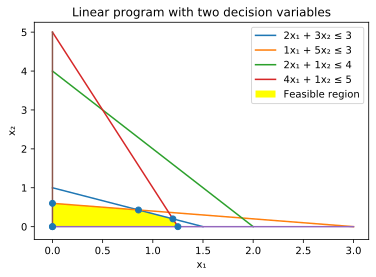

In [5]:
plot_constraints(A, b) 
plot_feasible_region(A, b)    
plt.xlabel('x₁')
plt.ylabel('x₂')
plt.title('Linear program with two decision variables')
plt.legend()
plt.show()

--- Vertices of feasible region ---
value = 3x₁ + 1x₂
x₁=0.000, x₂=0.000, value=0.000
x₁=0.000, x₂=0.600, value=0.600
x₁=0.857, x₂=0.429, value=3.000
x₁=1.200, x₂=0.200, value=3.800
x₁=1.250, x₂=0.000, value=3.750
x₁=0.000, x₂=0.000, value=0.000

--- Simplex method iterations ---
x₁=0.000, x₂=0.000, value=-0.000
x₁=1.250, x₂=0.000, value=3.750
x₁=1.200, x₂=0.200, value=3.800


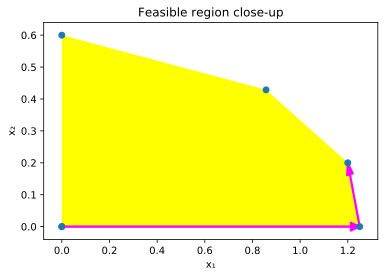

In [6]:
print('--- Vertices of feasible region ---')
print('value = {}x₁ + {}x₂'.format(alpha, beta))
vertices = feasible_vertices(A, b)
for x1, x2 in zip(*vertices):
    print('x₁={:.3f}, x₂={:.3f}, value={:.3f}'.format(
        x1, x2, np.array((x1, x2)) @ (alpha, beta)
    ))
    
print()
solution = simplex_2d(alpha, beta, A, b)
print('--- Simplex method iterations ---')
for idx, it in enumerate(solution):
    print('x₁={:.3f}, x₂={:.3f}, value={:.3f}'.format(
        it['solution'][0], it['solution'][1], it['value']
    ))
    

plot_feasible_region(A, b)
plot_solution(solution)
plt.xlabel('x₁')
plt.ylabel('x₂')
plt.title('Feasible region close-up')
plt.show()